## **Validación cruzada. Dev/hold-out. Optimización de hiperparámetros.**

En esta primera práctica de la clase nos enfocaremos en los tres temas enunciados en el título.

- - -

### `1. Validación cruzada`

A la hora de evaluar nuestro modelo, ¿cómo podemos garantizar que su desempeño es independiente de la separación de los datos que hayamos realizado?

La validación cruzada es una técnica utilizada para evaluar los resultados de un análisis estadístico y garantizar que esos resultados sean independientes de la partición entre datos de entrenamiento y datos de testeo. Con esta técnica, a su vez, resulta más fácil detectar el overfitting.

Una de las formas más conocidas de emplear esta técnica es a través de **k-folds**. K refiere al número de grupos en los cuales se va a dividir la muestra de datos, convirtiéndose uno de ellos en set de prueba y los restantes grupos en set de entrenamiento. Luego, se itera.

El performance del modelo será el promedio de las K evaluaciones. También es importante considerar la desviación estándar.

<img src = "https://upload.wikimedia.org/wikipedia/commons/f/f2/K-fold_cross_validation.jpg">

Por el momento, veníamos utilizando una metodología que se asemejaría a la iteración 1 del gráfico supra. Del total de datos, dividíamos una parte en datos de prueba y otra en datos de entrenamiento. Pero esto se mantenía fijo ya que no iterábamos.

Supongamos que tenemos un dataset con ciertos atributos $X$ y una variable de salida $y$. Cada instancia puede tener como valor de salida un 0 o un 1 -es decir, estamos frente a un problema de clasificación binaria-. Si hacemos un único train-test split, podría pasar que los subsets de entrenamiento y testeo sean muy heterogéneos entre sí pero muy homogéneos en su interior, fruto del azar de esa división. Para evitar esto, recurrimos a ***cross-validation***.

<img src = "https://upload.wikimedia.org/wikipedia/commons/1/18/Esquema_castell%C3%A0.jpg" height = 400>

Pasemos, ahora sí, a ver la implementación de esta técnica.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# Trabajaremos con un dataset provisto por scikit-learn de diagnóstico de cáncer.

from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

In [3]:
# Lo convertimos a DataFrame

df = pd.DataFrame(np.c_[data['data'], data['target']],
                  columns= np.append(data['feature_names'], ['target']))

In [4]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

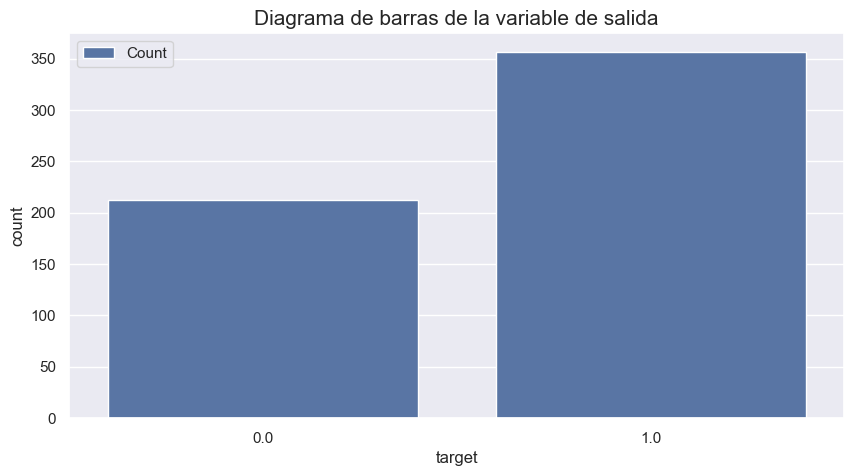

In [6]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'target' ,label= 'Count', data = df)
plt.title('Diagrama de barras de la variable de salida', fontsize = 15)
plt.show()

In [7]:
# Nos quedamos solamente con los primeros 10 atributos para simplificar el proceso

features_mean = list(df.columns[0:10])
features_mean

['mean radius',
 'mean texture',
 'mean perimeter',
 'mean area',
 'mean smoothness',
 'mean compactness',
 'mean concavity',
 'mean concave points',
 'mean symmetry',
 'mean fractal dimension']

In [8]:
# Agregamos la variable de salida

df = df[features_mean + ['target']]
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.0


C:\Users\dmon2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


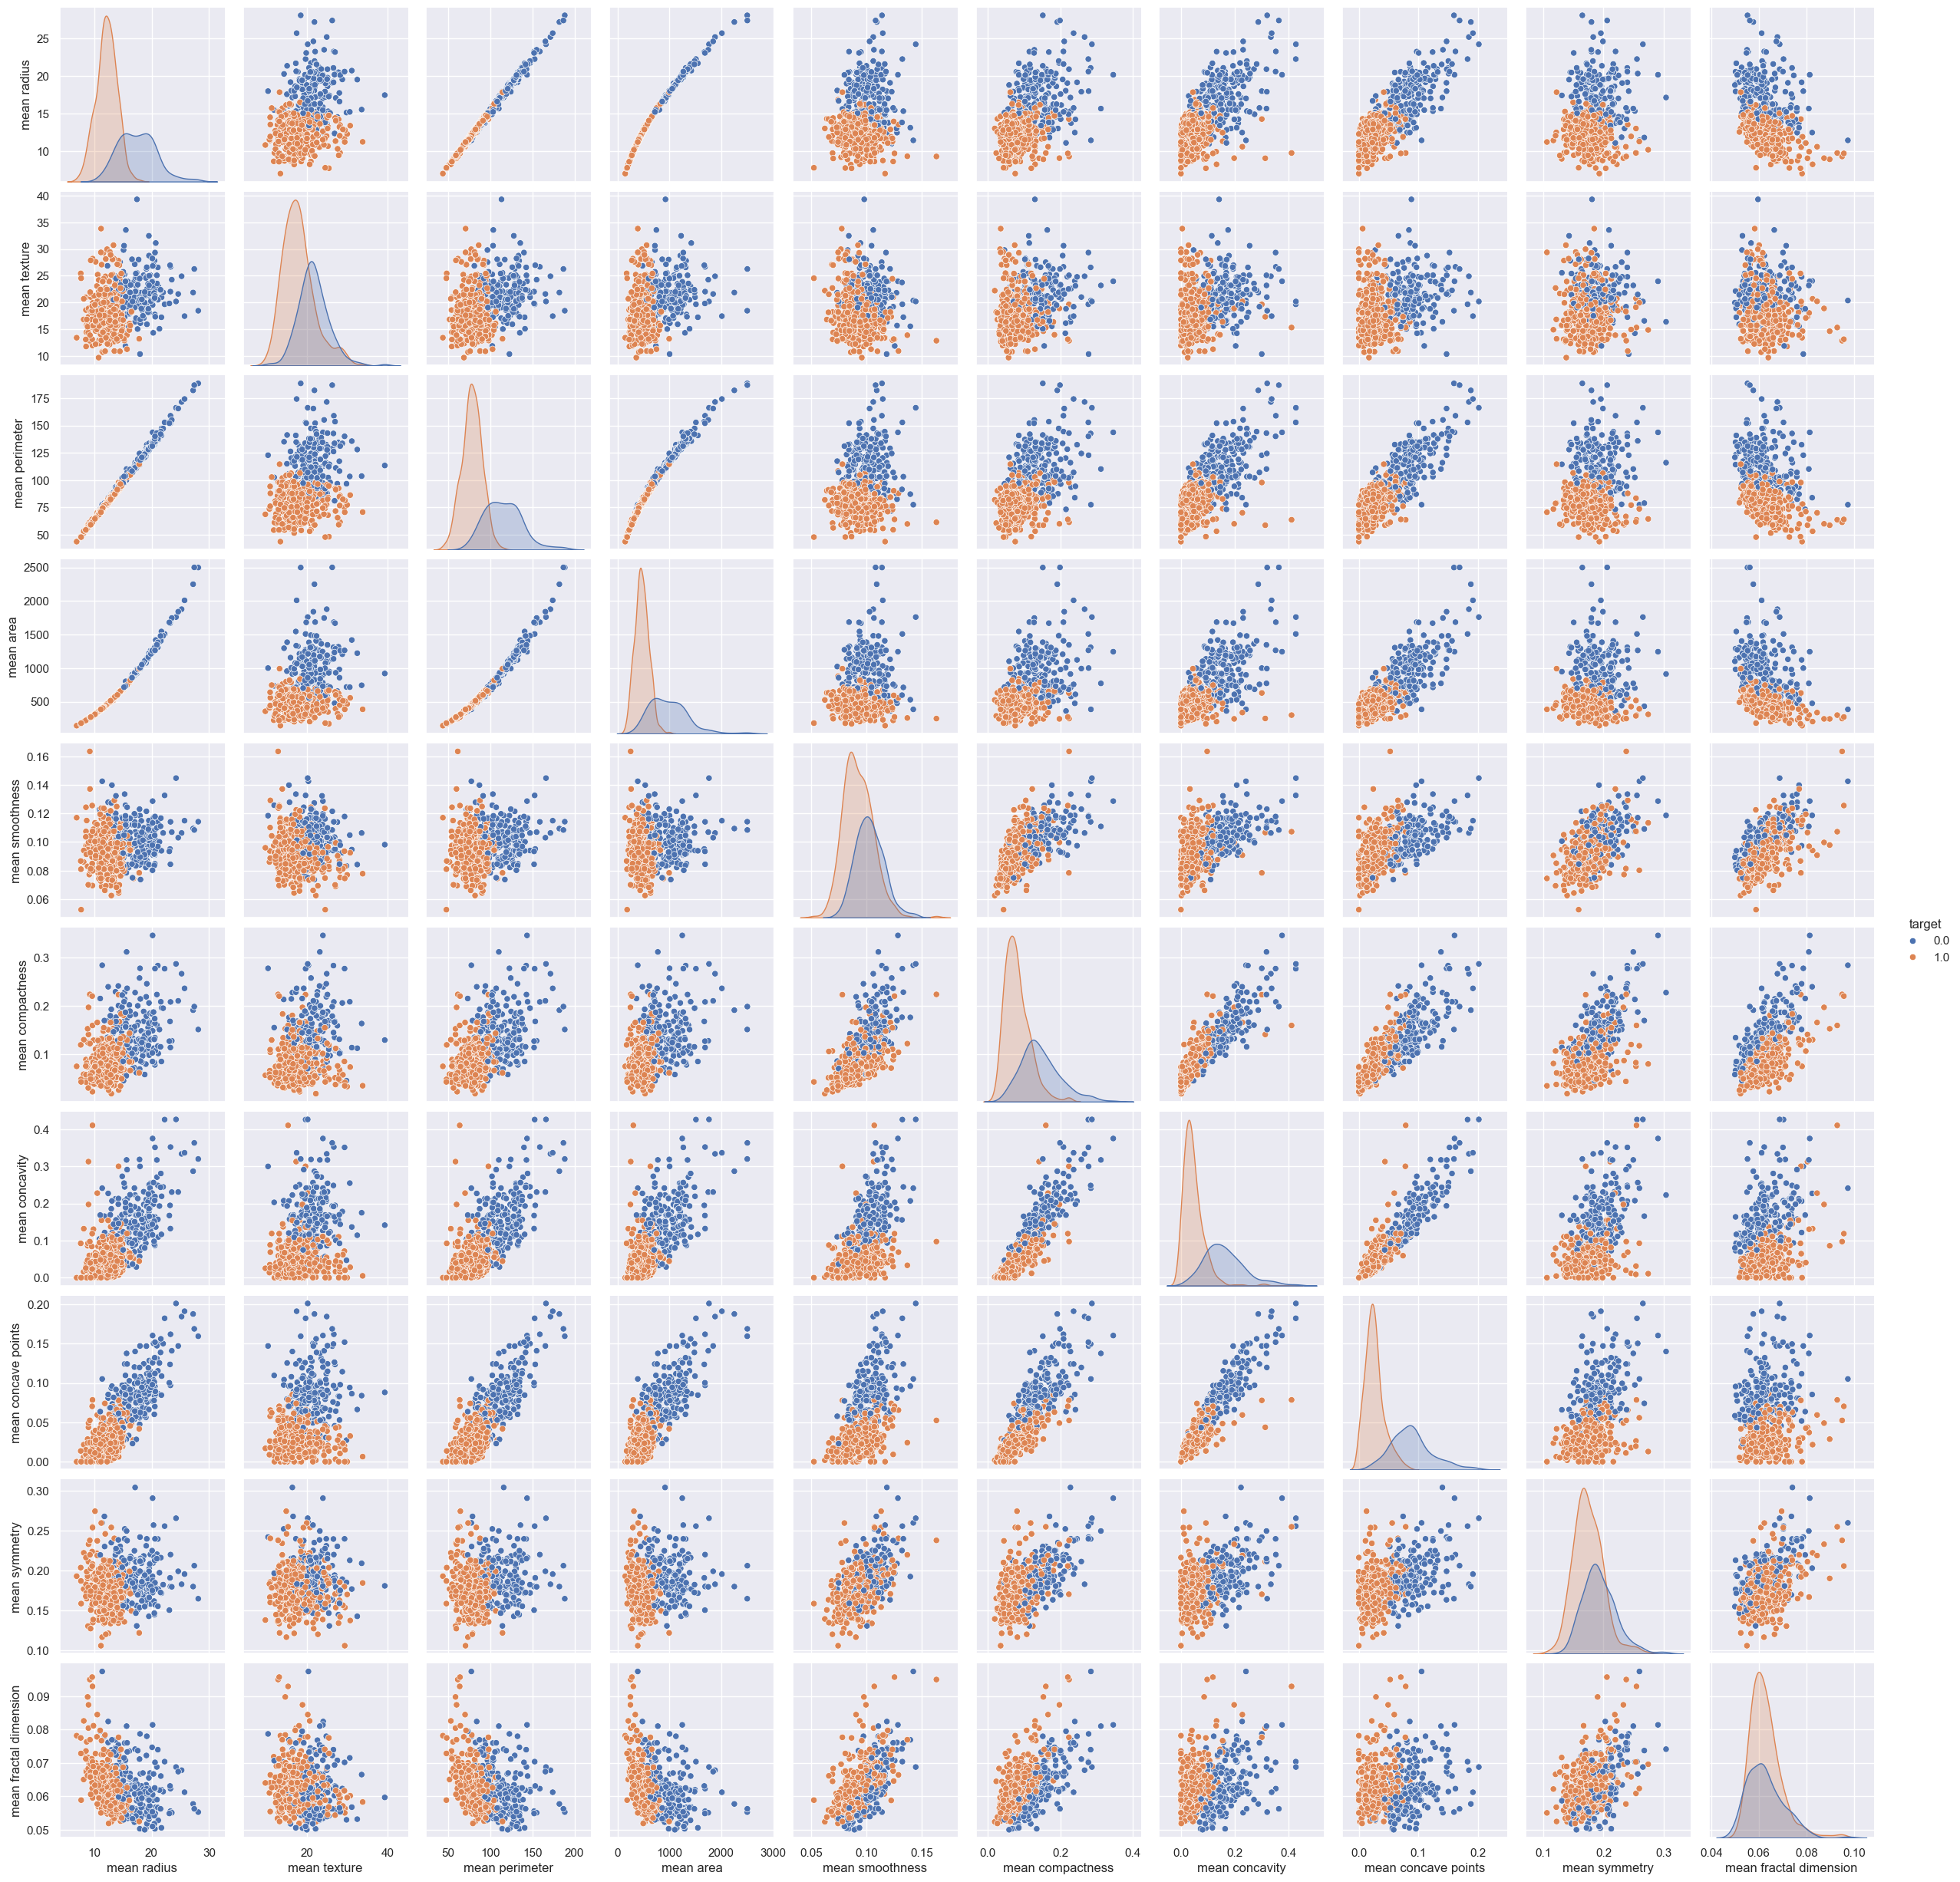

In [9]:
# Hacemos un pairplot

sns.pairplot(df, hue = 'target')
plt.show()

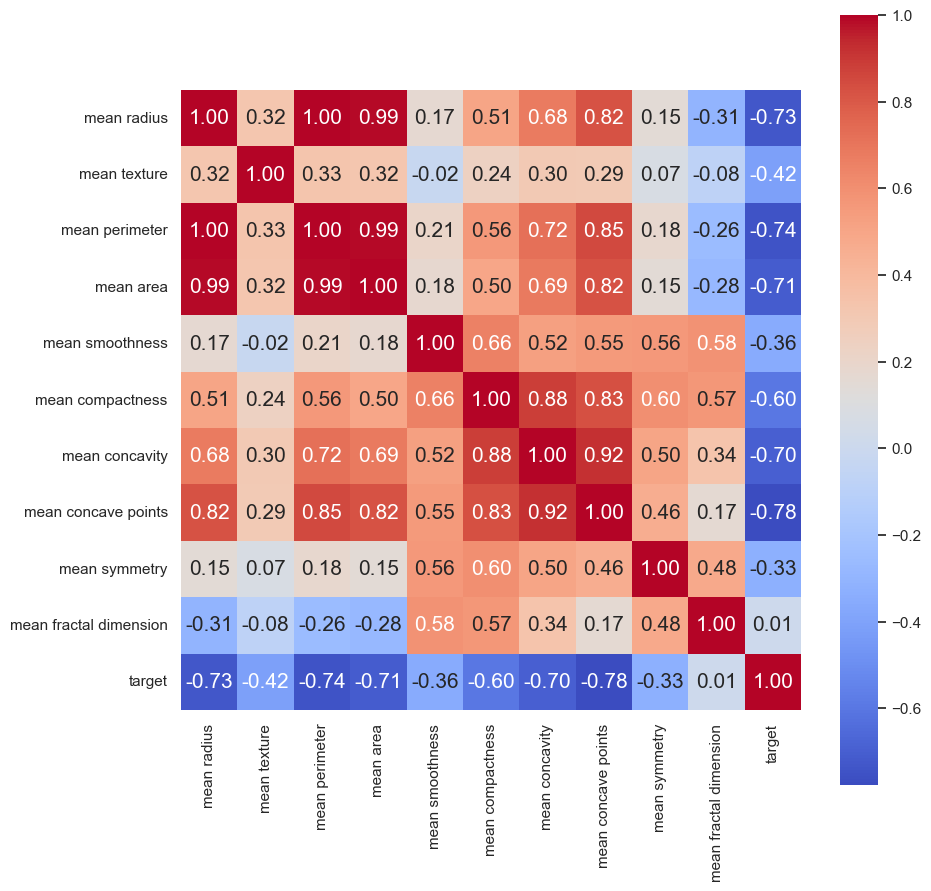

In [10]:
# Realizamos el mapa de calor para ver la correlación entre las variables

corr = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= df.columns,
           yticklabels= df.columns,
           cmap= 'coolwarm')
plt.show()

### Entrenamiento de los modelos

Vamos a entrenar un árbol profundidad infinita y un modelo K-NN con un vecino. Los vamos a entrenar y evaluar haciendo un `train_test_split`, dejando un 10% de los datos para testeo.

In [11]:
# Seleccionamos las variables predictoras X y la variable a predecir y

X = df[['mean radius','mean smoothness', 'mean compactness','mean symmetry','mean fractal dimension']]
y = df['target']

In [12]:
# Realizamos un escalado de los datos. Esto se debe a que K-NN trabaja con distancias y no puede discernir la diferencia de escala y unidades entre cada una de las variables.

from sklearn.preprocessing import StandardScaler
scl = StandardScaler()
X = scl.fit_transform(X)

In [12]:
y.sum()/y.count()

0.6274165202108963

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123,stratify=y)

In [22]:
print('Proporción de etiquetas en set de entrenamiento:', y_train.sum()/y_train.count())
print('Proporción de etiquetas en set de testeo:', y_test.sum()/y_test.count())

Proporción de etiquetas en set de entrenamiento: 0.6263736263736264
Proporción de etiquetas en set de testeo: 0.631578947368421


In [23]:
print('Proporción de etiquetas positiva en los datos de Train: ', y_train.sum()/y_train.size)
print('Proporción de etiquetas positiva en los datos de Test: ', y_test.sum()/y_test.size)

Proporción de etiquetas positiva en los datos de Train:  0.6263736263736264
Proporción de etiquetas positiva en los datos de Test:  0.631578947368421


In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [25]:
# Instanciamos el árbol

tree = DecisionTreeClassifier(max_depth = None)
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [26]:
# Predecimos sobre nuestro set de entrenamiento

y_train_pred = tree.predict(X_train)

# Predecimos sobre nuestro set de test

y_test_pred = tree.predict(X_test)

# Comparamos con las etiquetas reales

print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 1.0
Accuracy sobre conjunto de Test: 0.8771929824561403


In [27]:
# Instanciamos un modelo de vecinos más cercanos

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [28]:
# Predecimos sobre nuestro set de entrenamiento

y_train_pred = knn.predict(X_train)

# Predecimos sobre nuestro set de test

y_test_pred = knn.predict(X_test)

# Comparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 1.0
Accuracy sobre conjunto de Test: 0.868421052631579


***Para corroborar la incidencia de la división de los datos, modificar el valor de random_state a la hora de hacer train_test_split y correr todo de nuevo.***

In [29]:
# Importamos cross_val_score

from sklearn.model_selection import cross_val_score

In [30]:
tree = DecisionTreeClassifier()
tree_scores = cross_val_score(tree, X, y, cv=5)

knn = KNeighborsClassifier(n_neighbors=1)
knn_scores = cross_val_score(knn, X, y, cv=5)

In [31]:
print(tree_scores)
print(knn_scores)

[0.85087719 0.85964912 0.88596491 0.87719298 0.87610619]
[0.88596491 0.87719298 0.93859649 0.92105263 0.84955752]


In [32]:
print("Accuracy para Tree: %0.2f (+/- %0.2f)" % (tree_scores.mean(), tree_scores.std() * 2))
print("Accuracy para KNN: %0.2f (+/- %0.2f)" % (knn_scores.mean(), knn_scores.std() * 2))

Accuracy para Tree: 0.87 (+/- 0.03)
Accuracy para KNN: 0.89 (+/- 0.06)


In [33]:
# Ahora probamos con cross_validate. Esta función brinda un poco más de información

from sklearn.model_selection import cross_validate

In [34]:
tree_scores = cross_validate(tree, X, y, cv=5, scoring = ['precision','recall'])
knn_scores = cross_validate(knn, X, y, cv=5, scoring = ['precision','recall'])

In [35]:
print(tree_scores)

{'fit_time': array([0.01299334, 0.00999928, 0.04502487, 0.03599072, 0.04787731]), 'score_time': array([0.0189991 , 0.06090856, 0.01898932, 0.03500223, 0.03400469]), 'test_precision': array([0.85333333, 0.83333333, 0.90140845, 0.90277778, 0.92307692]), 'test_recall': array([0.90140845, 0.91549296, 0.88888889, 0.90277778, 0.84507042])}


In [36]:
print(knn_scores)

{'fit_time': array([0.03115845, 0.00609994, 0.01199985, 0.00897741, 0.00599813]), 'score_time': array([0.07441068, 0.14772177, 0.15205669, 0.32008123, 0.20586681]), 'test_precision': array([0.90277778, 0.88      , 0.95774648, 0.95652174, 0.921875  ]), 'test_recall': array([0.91549296, 0.92957746, 0.94444444, 0.91666667, 0.83098592])}


In [48]:
# Observemos todas las métricas que podemos usar para evaluar nuestros modelos

import sklearn
sorted(sklearn.metrics.get_scorer_names())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

- - -

### `2. Dev/hold-out`

Para optimizar hiperparámetros, que es el tercer punto que tocaremos en este notebook, previamente tenemos que incorporar estos conceptos.

A la hora de evaluar modelos, debemos hacer un primer train-test split. De esta forma, nos quedamos con el subconjunto de test que utilizaremos al final para calcular cuál es el mejor modelo.

<img src = "https://miro.medium.com/max/601/1*PdwlCactbJf8F8C7sP-3gw.png">


**Training set** será nuestro conjunto de desarrollo (dev). Aquí es donde haremos validación cruzada. En este conjunto, hacemos todas las pruebas que consideremos necesarias. Experimentamos con hiperparámetros. Evaluamos los modelos haciendo cross-validation.

Luego, elegimos un modelo a partir de este desempeño y lo evaluamos en **Test set**, que es nuestro conjunto **hold-out**.

- - -

### `3. Optimización de hiperparámetros`

Esta técnica se emplea para obtener el mejor modelo posible. Por supuesto, antes debemos elegir una métrica para comparar.

Existen tres estrategias para optimizar hiperparámetros -recordemos que son los parámetros de los modelos que define el datascientist antes de entrenar los modelos-:

+ Búsqueda manual: elegimos algunos hiperparámetros del modelo según nuestro criterio o experiencia previa. Es común probar con algunos valores a mano antes de pasar a algo más metódico. Esta estrategia resulta tediosa y poco eficiente.

+ Grid search: tomamos todos los hiperparámetros que queremos explorar y elegimos posibles valores. Luego, creamos un diccionario de hiperparámetros y entrenamos/validamos nuestro modelo en cada una de las combinaciones posibles. Posteriormente, elegimos la mejor combinación -el modelo con mejor performance según la métrica empleada-. Su principal inconveniente reside en que puede convertirse en un problema computacionalmente costoso. Cada modelo creado por grid search se evalúa con validación cruzada en el conjunto de Dev. Una vez elegidos los mejores hiperparámetros, debemos entrenar un modelo con esos hiperparámetros con todo el conjunto de Dev y evaluarlo en el conjunto de hold-out.

+ Random search: exploramos opciones y combinaciones al azar, a partir del diccionario creado. Luego entrenamos/validamos nuestro modelo con dichos valores y rescatamos aquel con mejor performance. Aquí se prueban menos combinaciones de hiperparámetros, pero más valores de cada uno de ellos. Esto se debe a que sampleamos en un rango de valores y no sobre una grilla regular.


Recalculando, para optimizar hiperparámetros necesitamos: una métrica, un modelo, un espacio de hiperparámetros y una estrategia.

Dejamos la documentación de [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) y de [random search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

In [49]:
# Continuamos con el dataset que estábamos usando

# Creamos la grilla de hiperparámetros para el modelo de vecinos más cercanos

param_grid = {'n_neighbors':np.arange(1, 20),
              'weights': ['uniform', 'distance'],
              'leaf_size':[1,3,5,7,10],
              'algorithm':['auto', 'kd_tree']}

In [50]:
type(param_grid)

dict

In [51]:
# Instanciamos el modelo KNN

knn = KNeighborsClassifier()

In [52]:
# Probamos la estrategia grid search

from sklearn.model_selection import GridSearchCV

# Le pasamos la grilla que creamos
model = GridSearchCV(knn, param_grid=param_grid, cv=5)

# Entrenamos
model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'kd_tree'],
                         'leaf_size': [1, 3, 5, 7, 10],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'weights': ['uniform', 'distance']})

Existen tres variables que nos informan la mejor combinación, la mejor performance y los resultados: `best_params_`, `best_score_` y `cv_results_`.

In [53]:
print("Mejores hiperparámetros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

scores = pd.DataFrame(model.cv_results_)
scores

Mejores hiperparámetros: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 14, 'weights': 'distance'}
Mejor Score: 0.9186813186813186



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_leaf_size,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008197,0.001941,0.038380,0.005094,auto,1,1,uniform,"{'algorithm': 'auto', 'leaf_size': 1, 'n_neigh...",0.890110,0.912088,0.912088,0.846154,0.912088,0.894505,0.025631,321
1,0.008558,0.001291,0.014324,0.006184,auto,1,1,distance,"{'algorithm': 'auto', 'leaf_size': 1, 'n_neigh...",0.890110,0.912088,0.912088,0.846154,0.912088,0.894505,0.025631,321
2,0.014058,0.002849,0.063358,0.008992,auto,1,2,uniform,"{'algorithm': 'auto', 'leaf_size': 1, 'n_neigh...",0.901099,0.890110,0.868132,0.824176,0.846154,0.865934,0.028146,371
3,0.009408,0.002152,0.028202,0.018410,auto,1,2,distance,"{'algorithm': 'auto', 'leaf_size': 1, 'n_neigh...",0.890110,0.912088,0.912088,0.846154,0.912088,0.894505,0.025631,321
4,0.006596,0.001744,0.068126,0.013945,auto,1,3,uniform,"{'algorithm': 'auto', 'leaf_size': 1, 'n_neigh...",0.923077,0.912088,0.879121,0.912088,0.890110,0.903297,0.016150,171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,0.006800,0.002312,0.011999,0.001418,kd_tree,10,17,distance,"{'algorithm': 'kd_tree', 'leaf_size': 10, 'n_n...",0.890110,0.934066,0.901099,0.912088,0.901099,0.907692,0.014906,61
376,0.005200,0.001935,0.038595,0.004177,kd_tree,10,18,uniform,"{'algorithm': 'kd_tree', 'leaf_size': 10, 'n_n...",0.890110,0.934066,0.879121,0.912088,0.890110,0.901099,0.019658,221
377,0.006598,0.002656,0.010598,0.002411,kd_tree,10,18,distance,"{'algorithm': 'kd_tree', 'leaf_size': 10, 'n_n...",0.901099,0.945055,0.879121,0.912088,0.901099,0.907692,0.021534,61
378,0.005787,0.001598,0.037181,0.004869,kd_tree,10,19,uniform,"{'algorithm': 'kd_tree', 'leaf_size': 10, 'n_n...",0.890110,0.934066,0.879121,0.912088,0.901099,0.903297,0.018906,171


In [54]:
#Predecimos en los datos de test con el mejor modelo obtenido
prediction = model.predict(X_test)

In [55]:
# Matriz de Confusion

from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(y_test,prediction)
print("Matriz de confusión:")
print(cm)

Matriz de confusión:
[[37  5]
 [ 3 69]]


In [56]:
print('Exactitud:', accuracy_score(y_test, prediction))

Exactitud: 0.9298245614035088


In [57]:
# Reporte de Clasificacion

from sklearn.metrics import classification_report

report = classification_report(y_test, prediction)
print("Reporte de Clasificación:")
print(report)

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.93      0.88      0.90        42
         1.0       0.93      0.96      0.95        72

    accuracy                           0.93       114
   macro avg       0.93      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114



Ahora probemos la estrategia `random search`.

In [58]:
# Grilla para random search

import scipy as sp
from scipy import stats

param_dist = {'n_neighbors':sp.stats.randint(1, 20),
              'weights': ['uniform', 'distance'],
              'leaf_size':sp.stats.randint(1, 10),
              'algorithm':['auto', 'kd_tree']}

In [59]:
from sklearn.model_selection import RandomizedSearchCV

knn = KNeighborsClassifier()
model = RandomizedSearchCV(knn, param_dist,n_iter=100, random_state=0, cv=5)

# Entrenamos knn con la grilla
model.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=100,
                   param_distributions={'algorithm': ['auto', 'kd_tree'],
                                        'leaf_size': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000025CD1353310>,
                                        'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000025CD13B7C90>,
                                        'weights': ['uniform', 'distance']},
                   random_state=0)

In [60]:
print("Mejores hiperparámetros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

scores = pd.DataFrame(model.cv_results_)
scores

Mejores hiperparámetros: {'algorithm': 'kd_tree', 'leaf_size': 7, 'n_neighbors': 14, 'weights': 'distance'}
Mejor Score: 0.9186813186813186



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_leaf_size,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009684,0.001561,0.009292,0.002651,auto,6,1,distance,"{'algorithm': 'auto', 'leaf_size': 6, 'n_neigh...",0.890110,0.912088,0.912088,0.846154,0.912088,0.894505,0.025631,83
1,0.011862,0.006786,0.011668,0.001212,kd_tree,4,8,distance,"{'algorithm': 'kd_tree', 'leaf_size': 4, 'n_ne...",0.923077,0.912088,0.879121,0.868132,0.923077,0.901099,0.023051,55
2,0.006914,0.002073,0.054427,0.005908,kd_tree,6,19,uniform,"{'algorithm': 'kd_tree', 'leaf_size': 6, 'n_ne...",0.890110,0.934066,0.879121,0.912088,0.901099,0.903297,0.018906,42
3,0.006168,0.002300,0.049162,0.010170,kd_tree,7,13,uniform,"{'algorithm': 'kd_tree', 'leaf_size': 7, 'n_ne...",0.890110,0.945055,0.901099,0.912088,0.912088,0.912088,0.018388,3
4,0.006962,0.005582,0.010853,0.004829,kd_tree,7,8,distance,"{'algorithm': 'kd_tree', 'leaf_size': 7, 'n_ne...",0.923077,0.912088,0.879121,0.868132,0.923077,0.901099,0.023051,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.007007,0.004283,0.013924,0.002663,auto,6,12,distance,"{'algorithm': 'auto', 'leaf_size': 6, 'n_neigh...",0.912088,0.923077,0.901099,0.901099,0.912088,0.909890,0.008223,10
96,0.007709,0.002852,0.012805,0.003169,auto,3,14,distance,"{'algorithm': 'auto', 'leaf_size': 3, 'n_neigh...",0.912088,0.945055,0.912088,0.912088,0.912088,0.918681,0.013187,1
97,0.009142,0.002782,0.010281,0.003853,kd_tree,7,11,distance,"{'algorithm': 'kd_tree', 'leaf_size': 7, 'n_ne...",0.890110,0.923077,0.901099,0.901099,0.912088,0.905495,0.011207,34
98,0.013562,0.002444,0.045881,0.005517,auto,1,4,uniform,"{'algorithm': 'auto', 'leaf_size': 1, 'n_neigh...",0.923077,0.901099,0.890110,0.879121,0.890110,0.896703,0.014906,76


In [61]:
#Predecimos en los datos de test

prediction = model.predict(X_test)

In [62]:
# Matriz de Confusion

cm = confusion_matrix(y_test,prediction)
print("Matriz de confusión:")
print(cm)

Matriz de confusión:
[[37  5]
 [ 3 69]]


In [63]:
# Reporte de Clasificacion
report = classification_report(y_test, prediction)
print("Reporte de Clasificación:")
print(report)

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.93      0.88      0.90        42
         1.0       0.93      0.96      0.95        72

    accuracy                           0.93       114
   macro avg       0.93      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114

